In this notebook, we will try to use `Swin Transformer V2` and `BERT large` without any fine-tuning to caption the images.
All training will be performed on `Nvidia A100 GPU` in `Google Colab`.

First we need to install some extra libraries to use ROUGE as an evaluation metric.

In [ ]:
!pip install -q evaluate
!pip install -q rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Tue Jun 17 01:55:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import os
import kagglehub

path = kagglehub.dataset_download('adityajn105/flickr8k')

print(f'Path to dataset files: {path}')
print(f'Files and directories: {os.listdir(path)}')

Path to dataset files: /kaggle/input/flickr8k
Files and directories: ['captions.txt', 'Images']


In [ ]:
with open('/kaggle/input/flickr8k/captions.txt') as f:
    captions = f.read()

print(captions[:500])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3


In [ ]:
os.listdir('/kaggle/input/flickr8k/Images')[:5]

['3226254560_2f8ac147ea.jpg',
 '214543992_ce6c0d9f9b.jpg',
 '2366643786_9c9a830db8.jpg',
 '3368819708_0bfa0808f8.jpg',
 '2190227737_6e0bde2623.jpg']

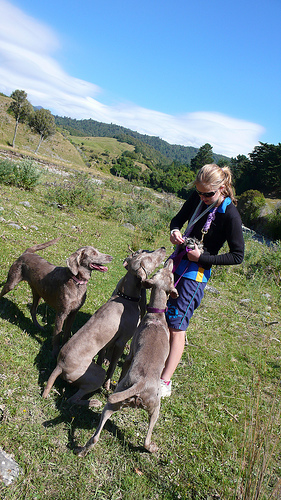

In [ ]:
from PIL import Image

Image.open('/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg')

In [ ]:
import io
import numpy as np
import pandas as pd

# Setting seed
np.random.seed(42)

# Load the captions string into a pandas DataFrame
buff = io.StringIO(captions)
df = pd.read_csv(buff)
# Construct the full path for each image file
df.image = df.image.apply (lambda im_path: os.path.join(path, 'Images', im_path))

df.head(10)

image  \
0  /kaggle/input/flickr8k/Images/1000268201_693b0...   
1  /kaggle/input/flickr8k/Images/1000268201_693b0...   
2  /kaggle/input/flickr8k/Images/1000268201_693b0...   
3  /kaggle/input/flickr8k/Images/1000268201_693b0...   
4  /kaggle/input/flickr8k/Images/1000268201_693b0...   
5  /kaggle/input/flickr8k/Images/1001773457_577c3...   
6  /kaggle/input/flickr8k/Images/1001773457_577c3...   
7  /kaggle/input/flickr8k/Images/1001773457_577c3...   
8  /kaggle/input/flickr8k/Images/1001773457_577c3...   
9  /kaggle/input/flickr8k/Images/1001773457_577c3...   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

In [ ]:
df = df.sort_values('image').reset_index(drop=True)

df.head(12).image.values

array(['/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
       '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg',
       '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg'],
      dtype=object)

In [ ]:
len(df), df.image.nunique(), 8091 // 2 + 1, 8091 // 2

(40455, 8091, 4046, 4045)

In [ ]:
df['random_rank'] = df.groupby('image').image.transform(
    lambda x: np.random.permutation(len(x))
)
df['is_train'] = df['random_rank'] < 4

df.head(12)

image  \
0   /kaggle/input/flickr8k/Images/1000268201_693b0...   
1   /kaggle/input/flickr8k/Images/1000268201_693b0...   
2   /kaggle/input/flickr8k/Images/1000268201_693b0...   
3   /kaggle/input/flickr8k/Images/1000268201_693b0...   
4   /kaggle/input/flickr8k/Images/1000268201_693b0...   
5   /kaggle/input/flickr8k/Images/1001773457_577c3...   
6   /kaggle/input/flickr8k/Images/1001773457_577c3...   
7   /kaggle/input/flickr8k/Images/1001773457_577c3...   
8   /kaggle/input/flickr8k/Images/1001773457_577c3...   
9   /kaggle/input/flickr8k/Images/1001773457_577c3...   
10  /kaggle/input/flickr8k/Images/1002674143_1b742...   
11  /kaggle/input/flickr8k/Images/1002674143_1b742...   

                                              caption  random_rank  is_train  
0   A child in a pink dress is climbing up a set o...            1      True  
1               A girl going into a wooden building .            4     False  
2    A little girl climbing into a wooden playhouse .            2      True  
3   A little girl climbing the stairs to her playh...            0      True  
4   A little girl in a pink dress going into a woo...            3      True  
5     Two dogs on pavement moving toward each other .            3      True  
6   A black dog and a white dog with brown spots a...            1      True  
7   Two dogs of different breeds looking at each o...            2      True  
8          A black dog and a spotted dog are fighting            0      True  
9   A black dog and a tri-colored dog playing with...            4     False  
10  A little girl covered in paint sits in front o...            1      True  
11  A little girl is sitting in front of a large p...            0      True

In [ ]:
# Check the number of samples in the train set
df.is_train.sum()

np.int64(32364)

In [ ]:
train_df = df[df.is_train]

res_df = df[~df.is_train]
res_df = res_df.sample(frac=1, random_state=42).reset_index(drop=True)

test_size = 4046
test_df = res_df.iloc[:test_size].reset_index(drop=True)
valid_df = res_df.iloc[test_size:].reset_index(drop=True)

# Check the distribution
len(train_df), len(test_df), len(valid_df)

(32364, 4046, 4045)

In [ ]:
import torch
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
sns.set()

In [ ]:
from transformers import AutoTokenizer

llm_id = 'google-bert/bert-large-uncased'
tokenizer = AutoTokenizer.from_pretrained(llm_id)

tokenizer.add_special_tokens({'pad_token': '[PAD]'})

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

0

In [ ]:
def get_num_tokens(text: str) -> int:
    return len(tokenizer(text).input_ids)

df['tokens_per_description'] = df.caption.map(get_num_tokens)

df.head()

image  \
0  /kaggle/input/flickr8k/Images/1000268201_693b0...   
1  /kaggle/input/flickr8k/Images/1000268201_693b0...   
2  /kaggle/input/flickr8k/Images/1000268201_693b0...   
3  /kaggle/input/flickr8k/Images/1000268201_693b0...   
4  /kaggle/input/flickr8k/Images/1000268201_693b0...   

                                             caption  random_rank  is_train  \
0  A child in a pink dress is climbing up a set o...            1      True   
1              A girl going into a wooden building .            4     False   
2   A little girl climbing into a wooden playhouse .            2      True   
3  A little girl climbing the stairs to her playh...            0      True   
4  A little girl in a pink dress going into a woo...            3      True   

   tokens_per_description  
0                      20  
1                      10  
2                      11  
3                      12  
4                      15

In [ ]:
df.tokens_per_description.max()

42

In [ ]:
from torch.utils.data import Dataset


class ImageCaptionDataset(Dataset):
    """Dataset that returns prcessed images with LVM processor and LLM tokenizer"""

    def __init__(self, df, processor, tokenizer, max_length=42):
        self.images = df.image.values.tolist()
        self.captions = df.caption.values.tolist()
        self.processor = processor
        self.tokenizer = tokenizer
        # Tokens from the text + [CLS] + [SEP] tokens
        self.max_length = max_length + 2

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Reading the image and getting pixel values
        image = Image.open(self.images[idx]).convert('RGB')
        im_inputs = self.processor(images=image, return_tensors='pt')
        pixel_values = im_inputs['pixel_values'].squeeze(0)

        # Tokenizing the caption and getting input ids
        caption = self.captions[idx]
        text_inputs = self.tokenizer(
            caption,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_length,
            truncation=True
        )

        input_ids = torch.tensor(text_inputs.input_ids)
        input_ids[input_ids == tokenizer.pad_token_id] = -100

        return pixel_values, input_ids

In [ ]:
from transformers import AutoImageProcessor

lvm_id = 'microsoft/swin-large-patch4-window12-384'
processor = AutoImageProcessor.from_pretrained(lvm_id, use_fast=True)

train_ds = ImageCaptionDataset(train_df, processor, tokenizer)
test_ds = ImageCaptionDataset(test_df, processor, tokenizer)
valid_ds = ImageCaptionDataset(valid_df, processor, tokenizer)

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

In [ ]:
# Verify the output of the dataset
train_ds[0]

(tensor([[[-1.1247, -0.1657, -0.3027,  ..., -2.0494, -2.0152, -2.0323],
          [-1.1932, -0.1657, -0.2856,  ..., -1.9980, -1.9467, -2.0837],
          [-1.2445, -0.1657, -0.2513,  ..., -1.9809, -2.0323, -1.8439],
          ...,
          [ 0.8789,  0.6734,  0.7591,  ...,  0.8104,  0.7591,  0.7591],
          [ 1.1358,  2.0263,  2.2489,  ...,  0.7933,  0.7762,  0.7762],
          [ 1.2557,  1.5297,  1.1358,  ...,  0.7933,  0.7419,  0.7762]],
 
         [[-1.0553,  0.2402,  0.1176,  ..., -1.9657, -1.9132, -1.9132],
          [-1.1078,  0.2402,  0.1352,  ..., -1.8782, -1.7906, -1.9482],
          [-1.1779,  0.2052,  0.1702,  ..., -1.8782, -1.8782, -1.6331],
          ...,
          [-0.5651, -0.3200,  0.2577,  ...,  1.2031,  1.1681,  1.2031],
          [-0.6001,  1.5532,  2.0084,  ...,  1.2206,  1.1856,  1.1856],
          [-0.3200,  0.4328, -0.3550,  ...,  1.2206,  1.1856,  1.1681]],
 
         [[-0.4798,  0.4265,  0.2348,  ..., -1.7522, -1.7173, -1.7522],
          [-0.5670,  0.3393,

In [ ]:
from transformers import VisionEncoderDecoderModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(lvm_id, llm_id).to(device)

# ids
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.generation_config.decoder_start_token_id = tokenizer.cls_token_id

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/791M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/791M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.b

In [ ]:
model

VisionEncoderDecoderModel(
  (encoder): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=192, out_features=192, bias=True)
                  (key): Linear(in_features=192, out_features=192, bias=True)
                  (value): Linear(in_features=192, out_features=192, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutpu

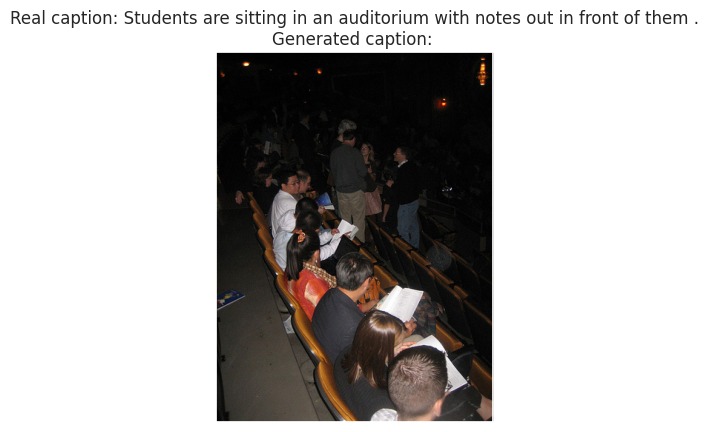

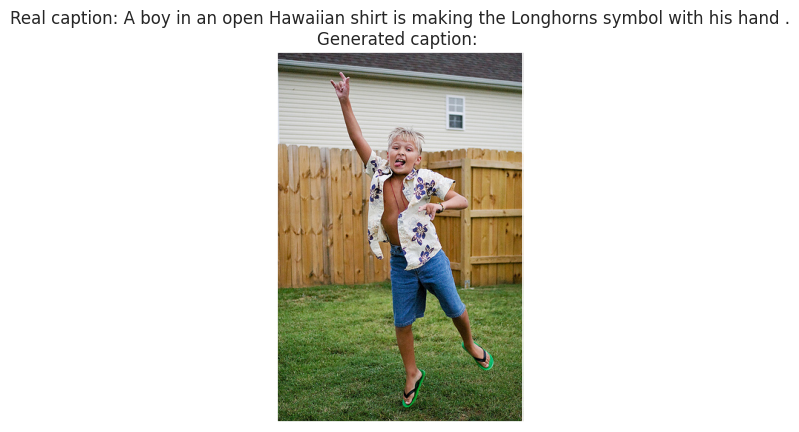

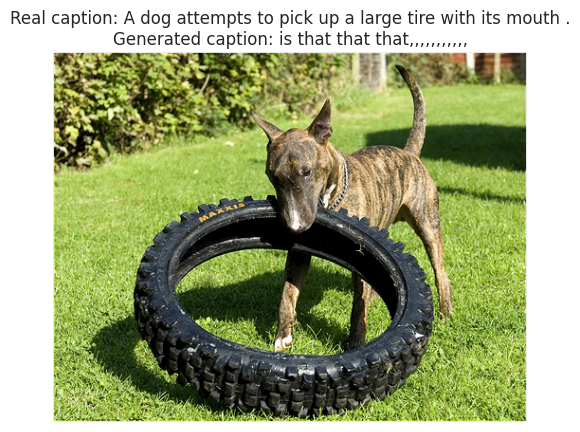

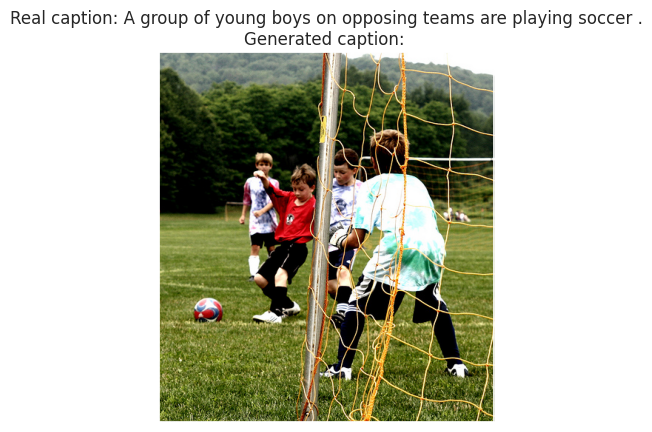

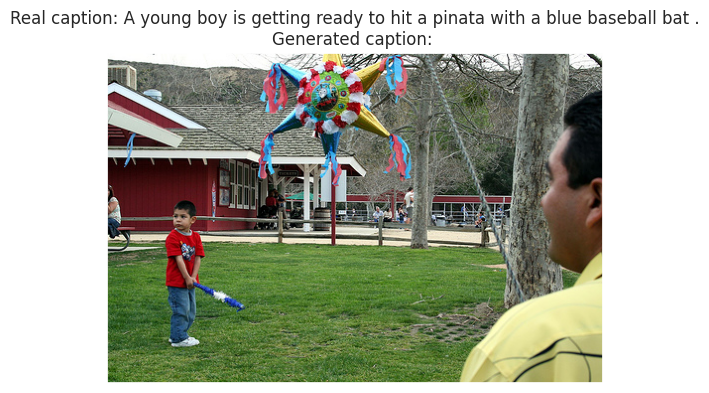

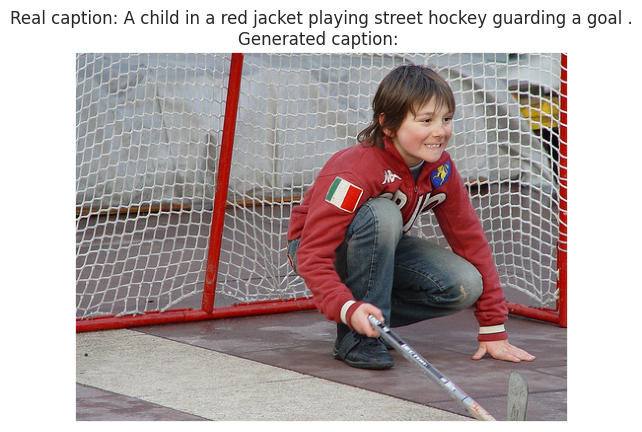

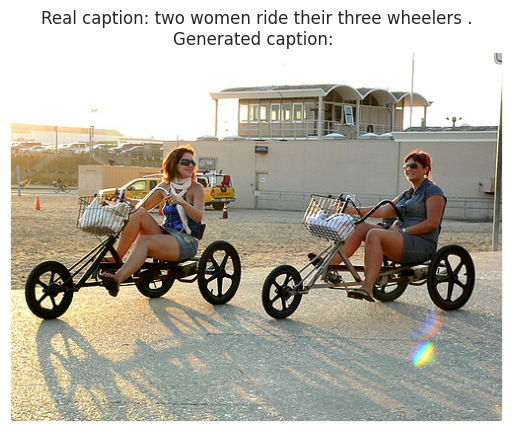

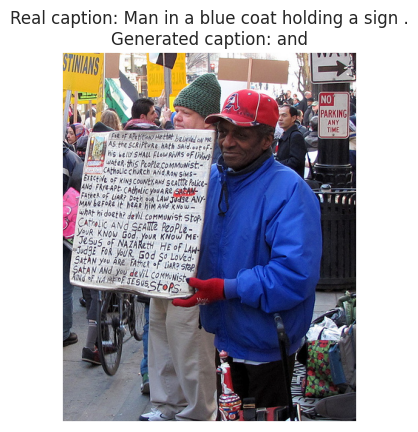

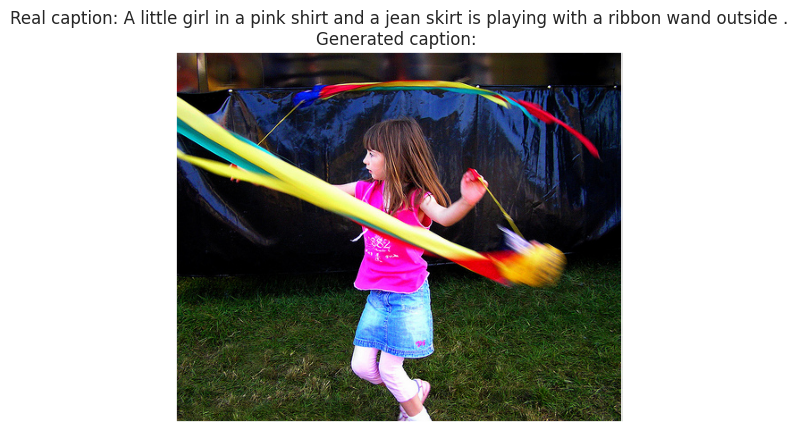

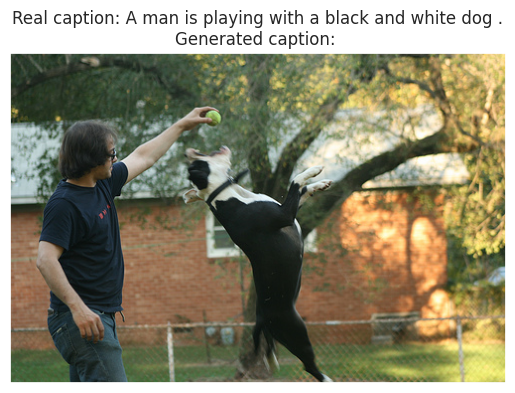

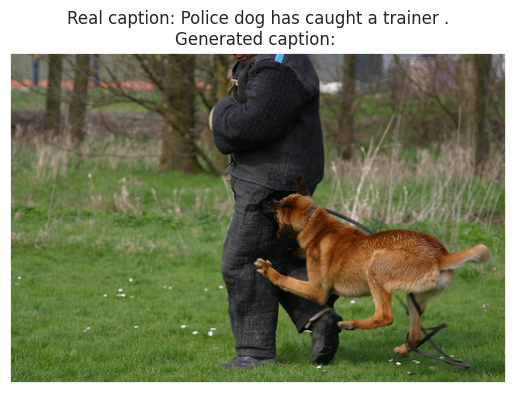

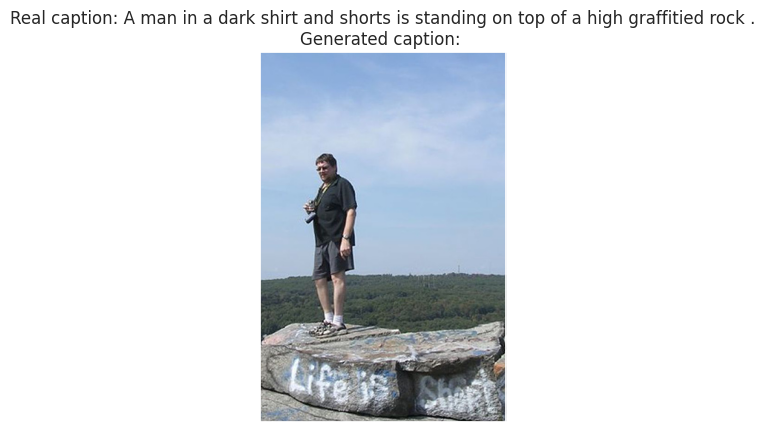

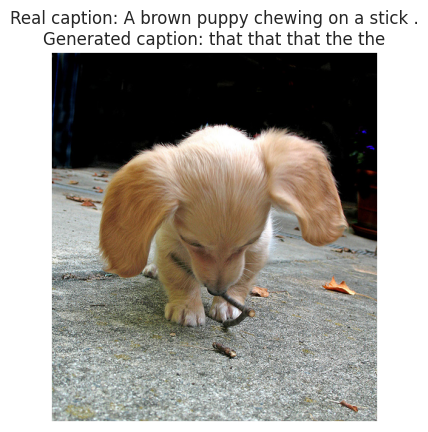

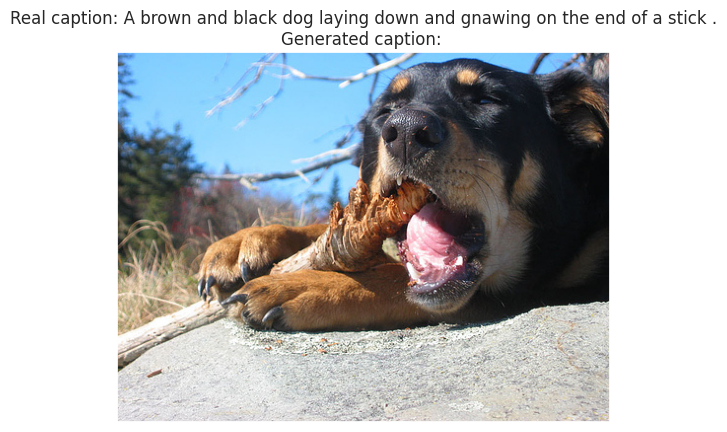

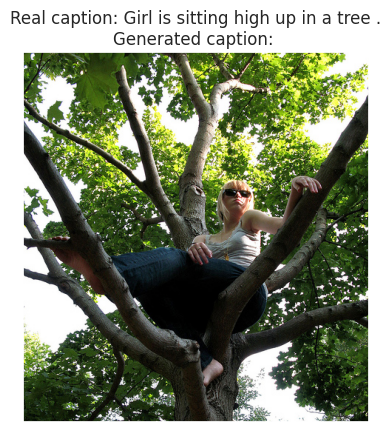

In [ ]:
model.eval()

ids = [125,  26, 119,  61, 102, 101,  23,  42, 111,  97, 122,  48,  54, 16,  95]

for i in ids:
    pixel_values = valid_ds[i][0].unsqueeze(0).to(device)
    predictions = tokenizer.decode(model.generate(pixel_values=pixel_values)[0], skip_special_tokens=True)
    fact = valid_df.loc[int(i), 'caption']
    caption = predictions.replace('.', '').strip()

    im = plt.imread(valid_df.iloc[i].image)
    title = f'Real caption: {fact}\nGenerated caption: {caption}'

    plt.imshow(im)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()

Out-of-the-box model can not even capture the image content. So, the best idea would be to change architecture for this task.